# Clustering

#### Identify clusters in our Ireland Shape file based on property prices.

Import Libraries

In [1]:
import numpy as np
import libpysal as lp
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
%matplotlib inline

C:\Users\callm\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now, we'll need the `scikit-learn` cluster module, which has quite a few tools that can be used to identify these clusters:

In [2]:
import sklearn.cluster as skc

# Areal clusters

In [3]:
irl = gpd.read_file('irl.shp').to_crs(epsg=3857)

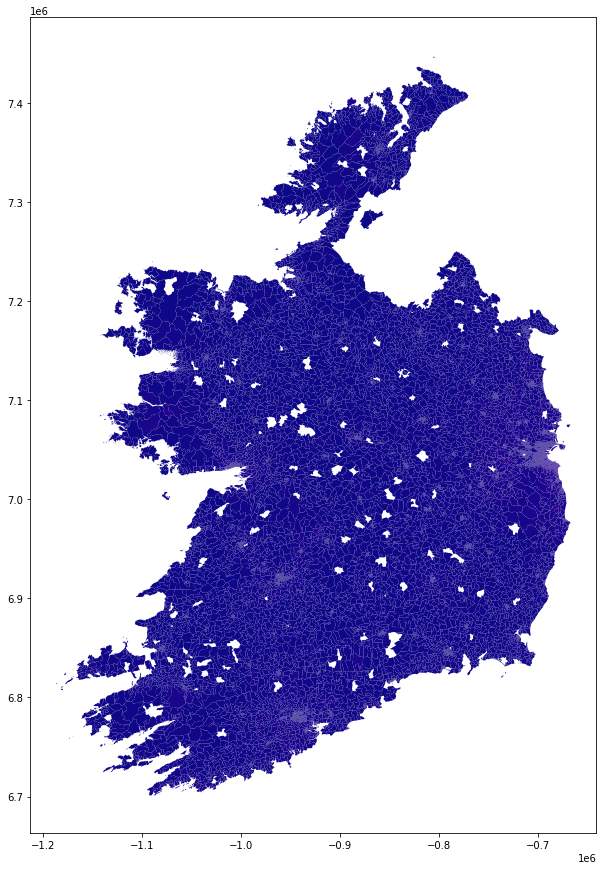

In [5]:
irl.plot('mean', cmap='plasma', figsize = (15,15))

One of the more helpful & flexible clusterers in `scikit-learn` is the ward agglomerative clusterer, which aims to build good clusters from pairwise aggregations of data

In [6]:
irl_priceclusters = skc.AgglomerativeClustering(n_clusters=6).fit(irl[['mean']])

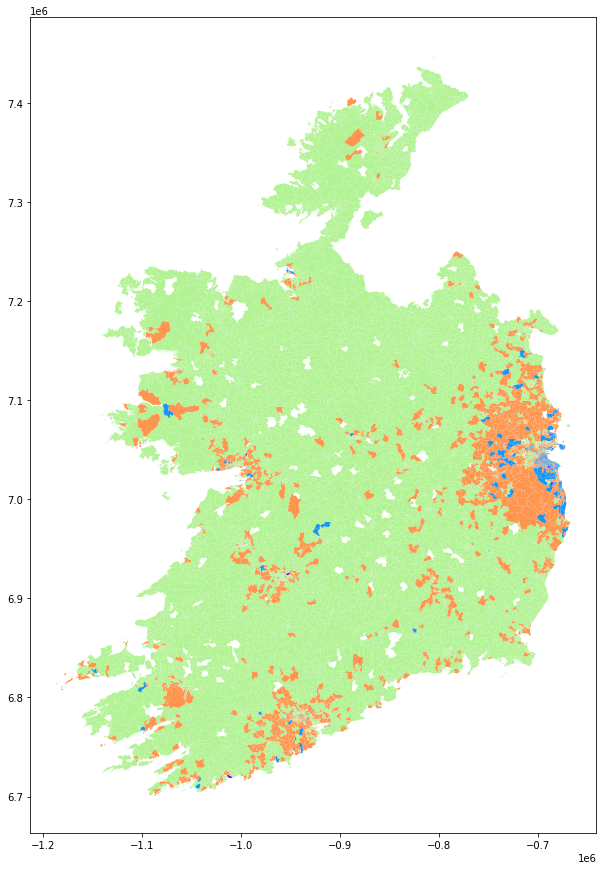

In [7]:
irl.assign(labels=irl_priceclusters.labels_).plot('labels', cmap='rainbow', figsize = (15,15))

Note that these are all broken up around the map; while we've found three clusters with similar prices, there is no guarantee that these solutions will be connected spatially, and indeed we often find that this is the case. 

As to measure the quality of clusters in the map, we can use the `silhouette score`, which is a standardized distance between each observation's data and the "decision boundary," or the nearest cluster that we *didn't* put the observation into. 

In [8]:
silhouettes = skm.silhouette_samples(irl[['mean']], irl_priceclusters.labels_)

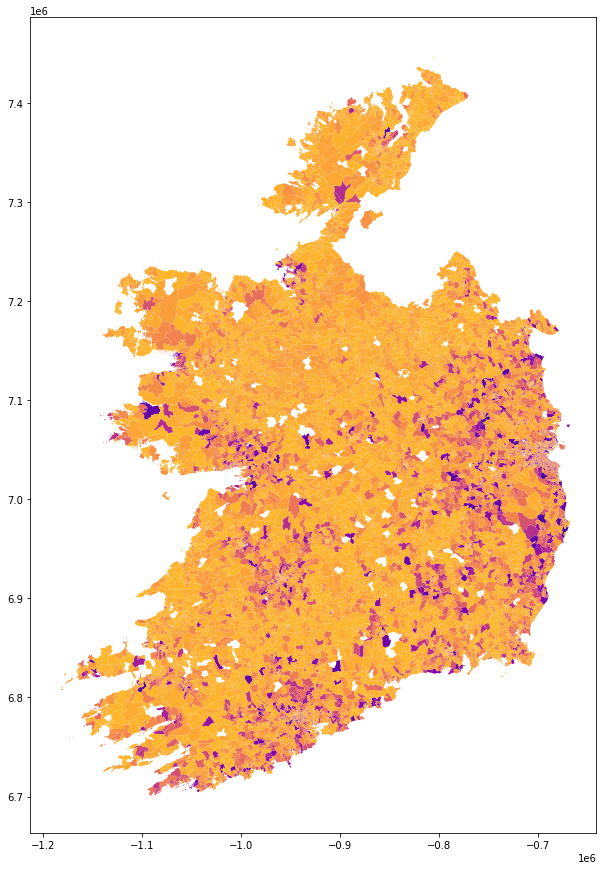

In [9]:
irl.assign(strength = silhouettes).plot('strength', cmap='plasma', vmin=-.5,vmax=1, figsize = (15,15))

The `mapclassify` package has some algorithms to do clustering as well, such as the Fisher Jenks optimal classification method, which finds solutions to k-means-style problems fast & efficiently:

In [10]:
import mapclassify

In [13]:
x = irl[['mean']]
mapclassify.FisherJenks(x, k=5).yb

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
x = irl[['mean']]
fisher = mapclassify.FisherJenks(x, k=5).yb
fisher

array([0, 0, 0, ..., 0, 0, 0])

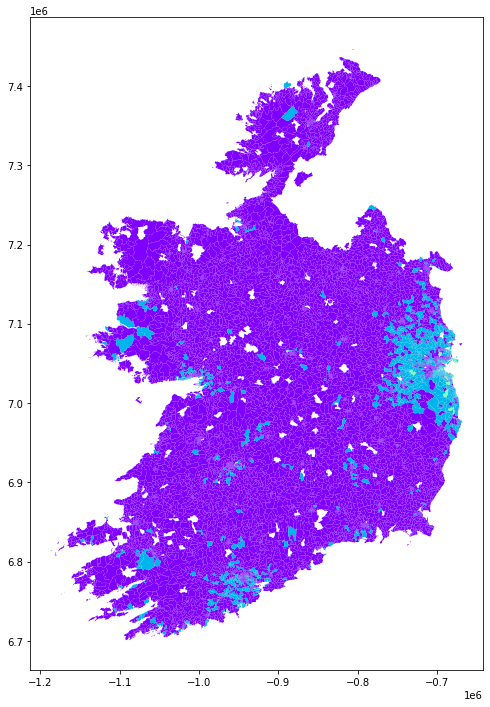

In [18]:
irl.assign(labels=fisher).plot('labels', cmap='rainbow', figsize = (12,12))

Sometimes, this outperforms the Agglomerative solutions:

In [19]:
silhouettes_fj = skm.silhouette_samples(irl[['mean']], fisher)

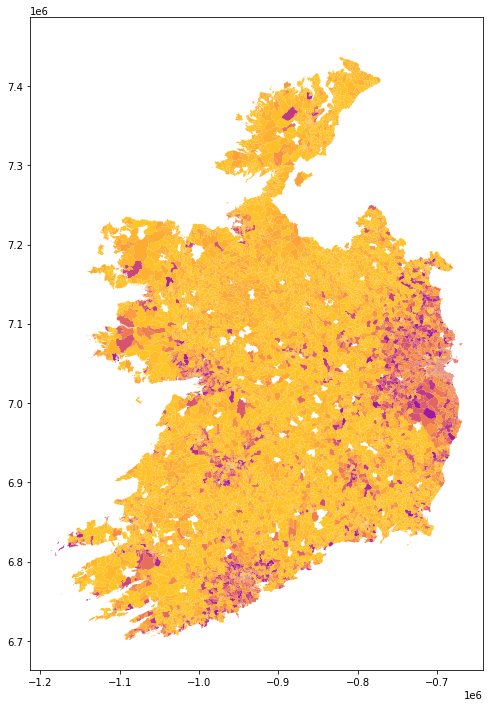

In [21]:
irl.assign(strength = silhouettes_fj).plot('strength', cmap='plasma', vmin=-.5,vmax=1, figsize = (12,12))

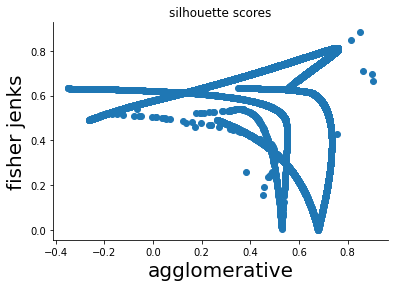

In [22]:
plt.scatter(silhouettes, silhouettes_fj)
plt.xlabel("agglomerative", fontsize=20)
plt.title("silhouette scores")
plt.ylabel("fisher jenks", fontsize=20)
sns.despine()

In [23]:
skm.silhouette_score(irl[['mean']], fisher)

0.6507465007741474

Another implementation in `scikit` is in their `KMeans` classifier. 

### Contiguous clusters

Finding contiguous clusters is much harder computationally.

But, we can adapt the agglomerative clusterer in scikit-learn to find contiguous clusters in our data using our connectivity graphs from `sds1-geography_as_feature.ipynb`:

In [24]:
rook_graph = lp.weights.Rook.from_dataframe(irl)

C:\Users\callm\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 2 islands with ids: 3154, 5525.
  warnings.warn(message)


the Agglomerative clustering configuration takes an argument, `connectivity`, which is used to constrain how individual observations are grouped together as the solution is being built. By passing the sparse matrix encoding our adjacency graph to this option, only adjcent observations will be grouped as the solution is built. This rule, only ever grouping neighboring observations, is sufficient to ensure that the resulting clusters are connected. 

In [25]:
irl_priceclusters_sp = skc.AgglomerativeClustering(n_clusters=5,
                                                         connectivity=rook_graph.sparse).fit(irl[['mean']])

C:\Users\callm\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 14 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


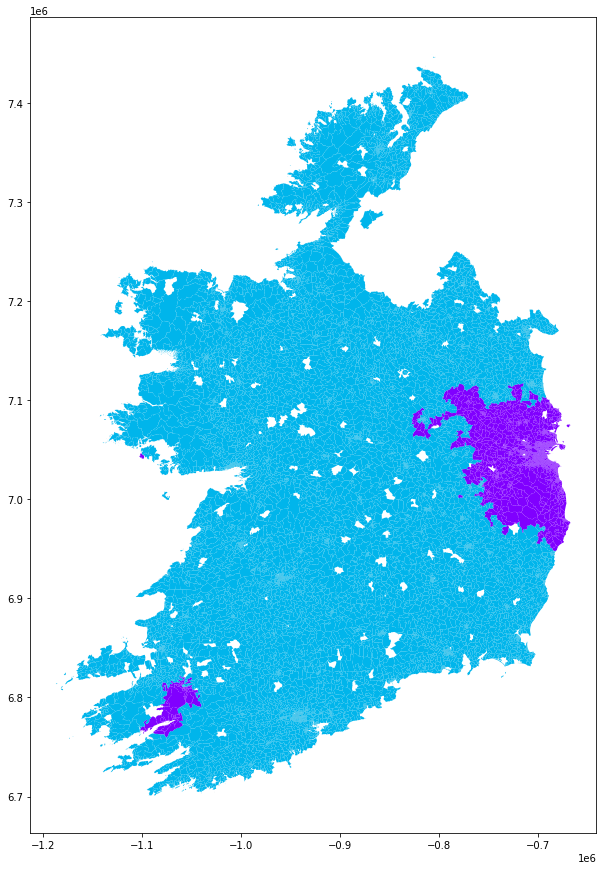

In [28]:
irl.assign(labels=irl_priceclusters_sp.labels_).plot('labels', cmap='rainbow', figsize = (15,15))

see?

### Probabilistic clustering

Sometimes, we'd rather treat clustering assignments as "predictions" in a probabilistic framework. Often, this is done either through latent dirichlet allocation or, more simply, through Gaussian mixture models. 

Scikit's gaussian mixture methods are also fast and simple to use, so Ill show them below:

In [29]:
import sklearn.mixture as skmix

Since Gaussian mixutre models are probabilistic, they are sensitive to the random seeds with which we populate the problem. Therefore, I'll pass today's date as a number to make sure the solutions are the same each time (but you don't have to use this seed!)

In [31]:
gmm = skmix.GaussianMixture(n_components=3, random_state=7052018).fit(irl[['mean']])

The Gaussian mixture models have a slightly different interface; to get the labels for the assignments on your trained classifier, you have to use the `predict` method:

In [32]:
predicted = gmm.predict(irl[['mean']])

Further, if you want the probabilities around the assignments, you can use the `predict_proba` method:

In [33]:
strengths = gmm.predict_proba(irl[['mean']])

This gives the full matrix of probabilities (over all clusters).

In [34]:
strengths[0:5]

array([[2.34164919e-02, 1.84028081e-04, 9.76399480e-01],
       [2.52800938e-02, 1.69087102e-04, 9.74550819e-01],
       [9.99434793e-02, 3.69213641e-04, 8.99687307e-01],
       [2.76734101e-02, 1.67919516e-04, 9.72158670e-01],
       [2.32365416e-02, 2.05172779e-04, 9.76558286e-01]])

So, just to focus on the probability of assignment to the "most likely" cluster, we can take the maximum probability over the rows of the `strengths` matrix:

In [35]:
strength = strengths.max(axis=1)

In [36]:
strength[0:5]

array([0.97639948, 0.97455082, 0.89968731, 0.97215867, 0.97655829])

now, we can make another map showing the assignments and the probabilities with which those assignments are made, kind of like our silhouette scores above:

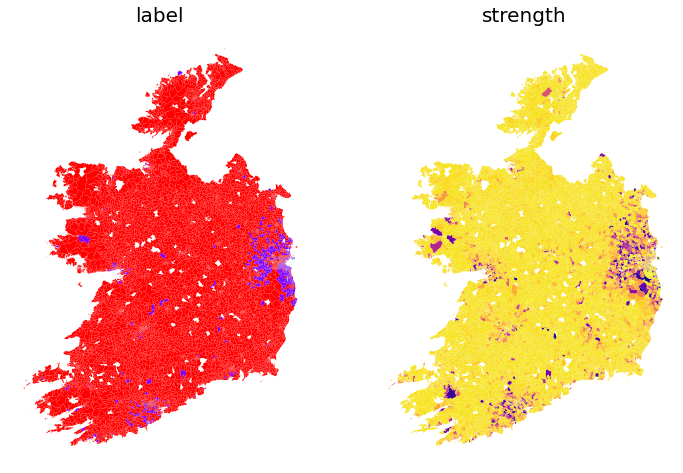

In [38]:
f,ax = plt.subplots(1,2,figsize=(12,12))
irl.assign(labels=predicted).plot('labels',ax=ax[0],cmap='rainbow')
irl.assign(strength=strength).plot('strength', cmap='plasma', ax=ax[1], vmin=.5, vmax=1)
for i in range(2):
    ax[i].axis('off')
    ax[i].set_title(["label","strength"][i], fontsize=20)

but, these assignment probabilities are *not* the same as the silhouette scores, and often have quite a different structure from the silhouette scores. 

In [39]:
silhouettes_gmm = skm.silhouette_samples(irl[['mean']], predicted)

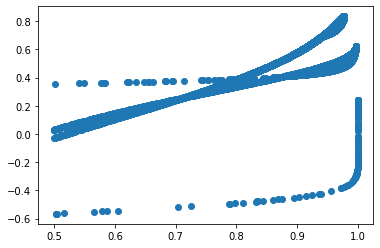

In [40]:
plt.scatter(strength, silhouettes_gmm)